In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from cbrain.imports import *
sys.path.append('../../../CBRAIN_TF/')

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## New unified class

In [3]:
range_dict = {
    'SPDT': [-5e-4, 5e-4],
    'SPDQ': [-5e-7, 5e-7],
    'QRL': [-2e-4, 2e-4],
    'QRS': [-1.2e-4, 1.2e-4],
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-5e-7, 5e-7],
}

In [109]:
class ModelDiagnostics(object):
    """
    Two basic functionalities:
    1. Plotting --> need preds and truth of selected time step in original values for one var
    2. Global statistics --> also from denormalized values
    
    Differences between TF and Keras:
    1. Data loading: For Keras I will use my data_generator (much faster), 
                     for TF I will read and process the raw aqua files
    2. Output normalization
    3. Output shape: 1D for Keras, 2D for TF --> Use TF convention
    NOTE: This cannot handle outputs with one level.
    """
    def __init__(self, is_tf, model_path, 
                 k_fpath=None, k_tpath=None, k_npath=None, k_norms=None,
                 tf_filepattern=None, tf_fvars=None, tf_tvars=None, tf_meanpath=None, 
                 tf_stdpath=None, nlat=64, nlon=128, nlev=30, ntime=48):
        # Basic setup
        self.is_tf = is_tf; self.is_k = not is_tf
        self.model = keras.models.load_model(model_path, custom_objects={"tf": tf})
        self.nlat, self.nlon, self.nlev = (nlat, nlon, nlev)
        self.ngeo = nlat * nlon
        self.ntime = ntime
        # Get variable names and open arrays
        if self.is_k: 
            self.k_norm = h5py.File(k_npath, 'r')
            self._get_k_norm_arrs(*k_norms)
            self.k_features = h5py.File(k_fpath, 'r')
            self.k_targets = h5py.File(k_tpath, 'r')
            self.fvars, self.tvars = self._get_k_vars()
        else:
            self.fvars, self.tvars = (tf_fvars, tf_tvars)
            self.tf_mean, self.tf_std = (nc.Dataset(tf_meanpath), nc.Dataset(tf_stdpath))
            self.tf_files = sorted(glob(tf_filepattern))
    
    # Init helper functions
    def _get_k_vars(self):
        """
        Return unique variable names for features and targets in correct order.
        """
        return [list(dict.fromkeys(
            [f.split('_lev')[0] for f in list(self.k_norm[f'{a}_names'][:])]
            )) for a in ['feature', 'target']]
    
    def _get_k_norm_arrs(self, fsub, fdiv, tsub, tmult):
        """
        Allocate normalization arrays for keras.
        """
        self.fsub = 0. if fsub is None else self.k_norm[fsub]
        if fdiv is None: self.fdiv = 1.
        elif fdiv == 'range': 
            self.fdiv = self.k_norm['feature_maxs'] - self.k_norm['feature_mins']
        elif fdiv == 'max_rs': self.fdiv = np.maximum(
            self.k_norm['feature_maxs'][:] - self.k_norm['feature_mins'][:],
            self.k_norm['feature_stds_by_var'])
        else: self.fdiv = self.k_norm['fdiv']
        self.tsub = 0. if tsub is None else self.k_norm[tsub]
        self.tmult = 1. if fsub is None else self.k_norm[tmult]
    
    
    def get_pt(self, itime, var=None):
        """
        Returns denormalized predictions and truth for a given time step and var.
        [lat, lon, lev] or [lat, lon, var, lev] if var is None
        """
        if self.is_k: p, t = self._get_k_pt(itime, var)
        else: p, t = self._get_tf_pt(itime, var)
        return p, t
    
    def _get_k_pt(self, itime, var=None):
        """Keras version"""
        f = (self.k_features['features'][itime*self.ngeo:(itime+1)*self.ngeo] -
             self.fsub) / self.fdiv
        p = self.model.predict_on_batch(f) / self.tmult + self.tsub
        t = self.k_targets['targets'][itime*self.ngeo:(itime+1)*self.ngeo]
        # At this stage they have shape [ngeo, stacked_levs]
        return self._k_reshape(p, var), self._k_reshape(t, var)
    
    def _get_tf_pt(self, itime=None, var=None, idate=None):
        """Tensorflow version
        If idate is given, instead of itime, return the entire file
        """
        if idate is None:
            idate = itime // self.ntime; itime_tmp = itime % self.ntime
        else: itime_tmp = None
        f = self._get_tf_f_or_t(idate, itime_tmp, 'f')
        p = self.model.predict_on_batch(f)
        t = self._get_tf_f_or_t(idate, itime_tmp, 't', normalize=False)
        p, t = (self._tf_reshape(p), self._tf_reshape(t))
        if var is None:
            return self._tf_denorm(p), t
        else:
            var_idx = self.tvars.index(var)
            return self._tf_denorm(p)[..., var_idx, :], t[..., var_idx, :]
        
    def _k_reshape(self, x, var=None):
        """For targets only atm.
        [ngeo, stacked_levs] --> [lat, lon, var, lev]
        Select var if not None.
        """
        x = x.reshape(self.nlat, self.nlon, -1, self.nlev)
        if var is not None: x = x[:, :, self.tvars.index(var), :]
        return x
    
    def _tf_reshape(self, x):
        """[ngeo, var, nlev] -- > [lat, lon, var, lev]
        or [ngeo*ntime, var, nlev] --> [ntime, lat, lon, var, lev]
        """
        ntar = len(self.tvars)
        if x.shape[0] == self.ngeo:
            return x.reshape(self.nlat, self.nlon, ntar, self.nlev)[:, :, :, ::-1]
        else:
            return x.reshape(self.ntime, self.nlat, self.nlon, ntar, self.nlev)[..., ::-1]
    
    def _get_tf_f_or_t(self, idate, itime, f_or_t, normalize=True):
        with nc.Dataset(self.tf_files[idate], 'r') as ds:
            arr = []
            vars = self.fvars if f_or_t == 'f' else self.tvars
            for var in vars:
                da = ds[var][:]
                if normalize: da = (da - self.tf_mean[var][:]) / self.tf_std[var][:]
                if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
                    a = np.rollaxis(da, 1, 4).reshape(-1, self.nlev)
                elif da.ndim == 3:   # 2D variables [time, lat, lon]
                    a = np.rollaxis(np.tile(da.reshape(-1), (self.nlev, 1)), 0, 2)
                elif da.ndim == 1:   # lat
                    a = np.rollaxis(np.tile(da, (self.ntime, self.nlev, self.nlon, 1)), 
                                    1, 4).reshape(-1, self.nlev)
                else:
                    raise Exception('Incompatible number of dimensions')
                arr.append(a)
            arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
        arr =  arr[:, :, -self.nlev:][:, :, ::-1]
        if itime is not None: arr = arr[itime*self.ngeo:(itime+1)*self.ngeo]
        return arr
    
    def _tf_denorm(self, x, f_or_t='t'):
        for i, var in enumerate(self.fvars if f_or_t == 'f' else self.tvars):
            m, s = [np.rollaxis(ds[var][-self.nlev:], 0, 3) 
                    for ds in [self.tf_mean, self.tf_std]]
            x[..., i, :] = x[..., i, :] * s + m
        return x
    
    # Plotting functions
    def plot_double_xy(self, itime, ilev, var, **kwargs):
        p, t = self.get_pt(itime, var)
        return self.plot_double_slice(p[:, :, ilev], t[:, :, ilev], **kwargs)
        
    def plot_double_yz(self, itime, ilon, var, **kwargs):
        p, t = self.get_pt(itime, var)
        return self.plot_double_slice(p[:, ilon, :].T, t[:, ilon, :].T, **kwargs)
        
    def plot_double_slice(self, p, t, title='', unit='', **kwargs):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        I1 = axes[0].imshow(p, **kwargs)
        I2 = axes[1].imshow(t, **kwargs)
        cb1 = fig.colorbar(I1, ax=axes[0], orientation='horizontal')
        cb2 = fig.colorbar(I2, ax=axes[1], orientation='horizontal')
        cb1.set_label(unit); cb2.set_label(unit)
        axes[0].set_title('CBRAIN Predictions')
        axes[1].set_title('SP-CAM Truth')
        fig.suptitle(title)
        return fig
        
    def plot_slice(self, x, title='', unit='', **kwargs):
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        I = ax.imshow(x, **kwargs)
        cb = fig.colorbar(I, ax=ax, orientation='horizontal')
        cb.set_label(unit)
        ax.set_title(title)
        return fig
    
    # Statistics computation
    def compute_stats(self, niter=None):
        """Compute statistics in for [lat, lon, var, lev]"""
        if self.is_k: nt = self.k_features['features'].shape[0] // self.ngeo
        else: nt = len(self.tf_files) * self.ntime
        if niter is not None: nt = niter
        # Allocate stats arrays
        psum = np.zeros((self.nlat, self.nlon, len(self.tvars), self.nlev))
        tsum = np.copy(psum); sse = np.copy(psum)
        psqsum = np.copy(psum); tsqsum = np.copy(psum)
        for itime in tqdm(range(nt)):
            if self.is_k:
                p, t = self.get_pt(itime)   # [lat, lon, var, lev]
            else:   # For TF load entire aqua file at once!
                itmp = itime % self.ntime; idate = itime // self.ntime
                if itmp == 0:
                    pday, tday = self._get_tf_pt(idate=idate)
                p, t = (pday[itmp], tday[itmp])
            # Compute statistics
            psum += p; tsum += t
            psqsum += p ** 2; tsqsum += t ** 2
            sse += (t - p) ** 2
        # Compute average statistics
        self.stats = {}
        pmean = psum / nt; tmean = tsum / nt
        self.stats['bias'] = pmean - tmean
        self.stats['mse'] = sse / nt
        # -1 for sample variance
        self.stats['pred_var'] = (psqsum / nt - pmean ** 2) * nt / (nt - 1)
        self.stats['true_var'] = (tsqsum / nt - tmean ** 2) * nt / (nt - 1)
        self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
            
    def mean_stats(self, cutoff_level=0):
        """Get average statistics for each variable and returns dataframe"""
        df = pd.DataFrame(index=self.tvars + ['all'],
            columns=list(self.stats.keys()))
        for ivar, var in enumerate(self.tvars):
            for stat_name, stat in self.stats.items():
                # Stats have shape [lat, lon, var, lev]
                df.loc[var, stat_name] = np.mean(stat[:, :, ivar])
            # compute r2
            df.loc[var, 'r2_v2'] = self._compute_r2(
                self.stats['mse'][:, :, ivar], self.stats['true_var'][:, :, ivar], cutoff_level)
        # Compute r2 for all vars
        df.loc['all', 'r2_v2'] = self._compute_r2(
            self.stats['mse'], self.stats['true_var'], cutoff_level)
        self.stats_df = df
        return df
    
    # Stats helper functions
    def _compute_r2(self, mse, true_var, cutoff_level=0):
        """r2 here is defined as the average r2 over each level
        mse and true_var have dims [lat, lon, lev]
        """
        lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))
        return np.mean(lev_r2[..., cutoff_level:])

### Keras

In [35]:
kmodel_path = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B018_purecrm_essv2_nonorm_sample1_max_rs.h5'
pp_dir = '/scratch/srasp/preprocessed_data/'
k_fpath = f'{pp_dir}purecrm_essv2_nonorm_valid_sample1_features.nc'
k_tpath = f'{pp_dir}purecrm_essv2_nonorm_valid_sample1_targets.nc'
k_npath = f'{pp_dir}purecrm_essv2_nonorm_train_sample1_norm.nc'
k_norms = ('feature_means', 'max_rs', None, 'target_conv')

In [110]:
d = ModelDiagnostics(False, kmodel_path, k_fpath=k_fpath, k_tpath=k_tpath, k_npath=k_npath, 
                     k_norms=k_norms)

In [111]:
d.compute_stats(5)

100%|██████████| 5/5 [00:00<00:00, 21.87it/s]
/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:203: RuntimeWarning: divide by zero encountered in true_divide


In [112]:
d.mean_stats(9)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide


,bias,mse,pred_var,true_var,r2,r2_v2
SPDQ,-6.22266e-12,1.19103e-15,1.65792e-16,1.4924e-15,-inf,0.094677
SPDT,-4.52211e-08,9.31302e-10,1.41147e-10,1.05544e-09,-inf,-0.008776
QRL,-7.98148e-09,1.32409e-10,1.93467e-11,5.47074e-11,-94045.5,-2.646135
QRS,1.12127e-08,2.22182e-11,1.15028e-11,1.62743e-11,-inf,-1.442013
all,NaN,NaN,NaN,NaN,NaN,-1.000562


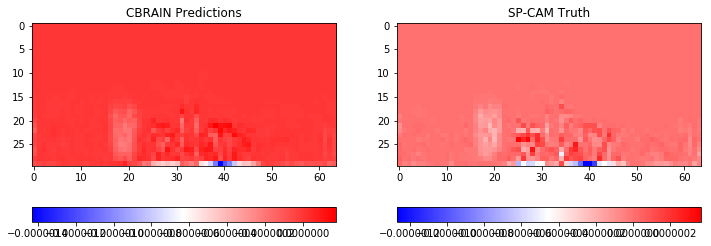

In [97]:
f = d.plot_double_yz(100, 20, 'SPDQ', cmap='bwr')

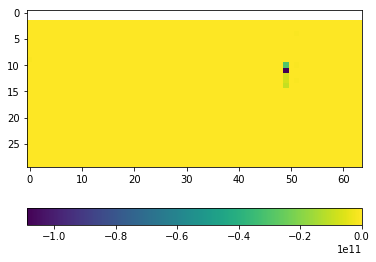

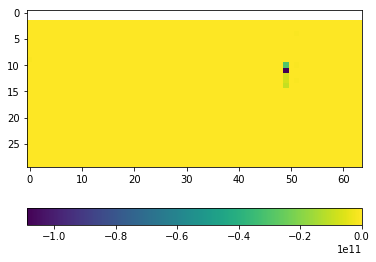

In [114]:
d.plot_slice(np.mean(d.stats['r2'][:, :, 0].T, axis=(1)))

### TF

In [6]:
model_dir = '/export/home/srasp/TF_models/'
model_fn = 'saved_keras_model_0220a.h5'
mean_fn = 'mean_nolat_0213.nc'
std_fn = 'std_nolat_0213.nc'

In [7]:
model_path = model_dir + model_fn
mean_path = model_dir + mean_fn
std_path = model_dir + std_fn

In [8]:
inps = ['TBP','QBP','PS','SHFLX','LHFLX','dTdt_adiabatic','dQdt_adiabatic']
outps = ['TPHYSTND_NORAD','PHQ']

In [55]:
data_dir = '/scratch/srasp/Aquaplanet_enhance05_old_matlab/'
aqua_fn = 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc'
aqua_pattern = data_dir + 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-*-00000.nc'

In [76]:
d2 = ModelDiagnostics(True, model_path, tf_filepattern=aqua_pattern, tf_fvars=inps, 
                      tf_tvars=outps, tf_meanpath=mean_path, tf_stdpath=std_path)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [79]:
d2.compute_stats()

100%|██████████| 1488/1488 [05:12<00:00,  4.76it/s]


In [80]:
d2.mean_stats(9)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: divide by zero encountered in true_divide


,bias,mse,pred_var,true_var,r2
TPHYSTND_NORAD,-1.33588e-07,1.18403e-09,9.75044e-10,2.00293e-09,0.425508
PHQ,1.02141e-10,1.42846e-15,4.51759e-16,1.62692e-15,0.456077
all,NaN,NaN,NaN,NaN,0.440793


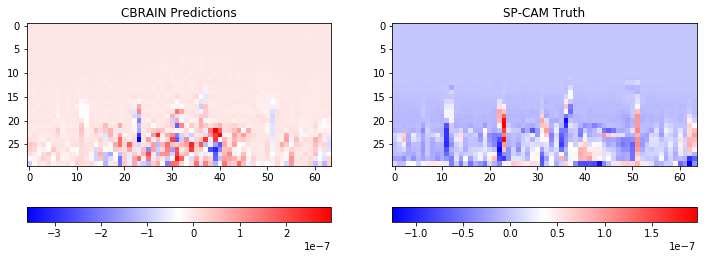

In [66]:
d2.plot_double_yz(100, 20, 'PHQ', cmap='bwr')

In [184]:
p, t = d2.get_pt(100, 'TPHYSTND_NORAD')

2 4 ['/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-02-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-03-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-04-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-05-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-06-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-07-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-08-00000.nc', '/scratch/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-09-00000.nc']


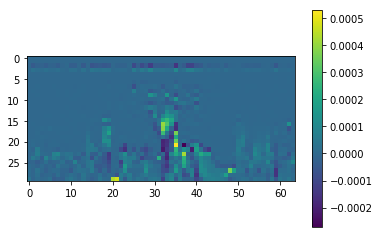

In [185]:
plt.imshow(t[:, 0, :].T); plt.colorbar()

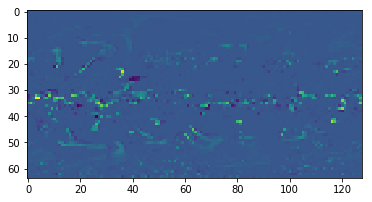

In [186]:
plt.imshow(t[:, :, 20])

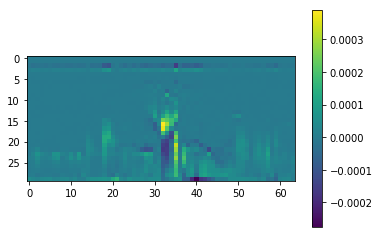

In [187]:
plt.imshow(p[:, 0, :].T); plt.colorbar()

In [169]:
f = d2._get_tf_f_or_t(2, 4, 'f')

In [170]:
f.shape

(8192, 7, 30, 1)

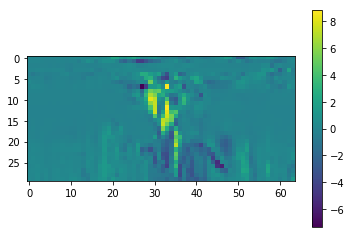

In [176]:
plt.imshow(f.reshape(64, 128, 7, 30)[:, 0, 0, :].T); plt.colorbar()

In [171]:
myp = d2.model.predict_on_batch(f)

In [172]:
myp.shape

(8192, 2, 30, 1)

In [ ]:
myp.reshape(64, 128, 2, 30)

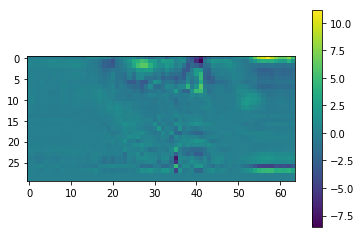

In [174]:
plt.imshow(myp.reshape(64, 128, 2, 30)[:, 0, 0, :].T); plt.colorbar()

In [ ]:
plt.imshow(f[:, 0, :].T); plt.colorbar()

In [102]:
old = ModelDiagnosticsTF(model_path, inps, outps, mean_path, std_path, aqua_pattern)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [129]:
to, po = old.get_tp('TPHYSTND_NORAD', 2, 4)

In [104]:
to.shape

(64, 128, 30)

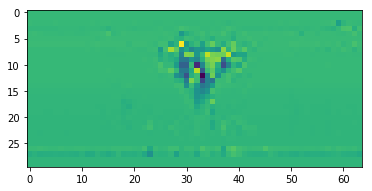

In [130]:
plt.imshow(to[:, 0, :].T)

## TF class

In [101]:
class ModelDiagnosticsTF(object):
    """
    Model diagnostics class.
    """
    def __init__(self, model_path, feature_vars, target_vars,
                 mean_path, std_path, valid_file_pattern, 
                 nlat=64, nlon=128, nlev=30):
        """
        TF version
        """
        self.model_path = model_path
        self.model = keras.models.load_model(model_path, custom_objects={"tf": tf})
        self.mean = nc.Dataset(mean_path, 'r')
        self.std = nc.Dataset(std_path, 'r')
        self.nlat = nlat; self.nlon = nlon; self.nlev = nlev
        self.ntime = 48
        self.ngeo = nlat * nlon
        self.feature_vars, self.target_vars = (feature_vars, target_vars)
        self.valid_files = sorted(glob(valid_file_pattern))

    def get_tp(self, var, idate, itime):
        """Return denormalized predictions and targets for one variable
        [lat, lon, lev]
        """
        # Get feature array
        f, t = self._get_ft(idate, itime)
        p = self._get_pred(f)
        var_idx = self.target_vars.index(var)
        t, p = (self.unravel(t), self.unravel(p))
        return self._denorm(t, 't')[:, :, var_idx], self._denorm(p, 't')[:, :, var_idx]
            
    def _get_f_or_t(self, idate, itime, f_or_t):
        with nc.Dataset(self.valid_files[idate], 'r') as ds:
            arr = []
            vars = self.feature_vars if f_or_t == 'f' else self.target_vars
            for var in vars:
                da = (ds[var][:] - self.mean[var][:]) / self.std[var][:]
                if da.ndim == 4:   # 3D variables [time, lev, lat, lon] --> [sample, lev]
                    a = np.rollaxis(da, 1, 4).reshape(-1, self.nlev)
                elif da.ndim == 3:   # 2D variables [time, lat, lon]
                    a = np.rollaxis(np.tile(da.reshape(-1), (self.nlev, 1)), 0, 2)
                elif da.ndim == 1:   # lat
                    a = np.rollaxis(np.tile(da, (self.ntime, self.nlev, self.nlon, 1)), 
                                    1, 4).reshape(-1, 30)
                else:
                    raise Exception('Incompatible number of dimensions')
                arr.append(a)
            arr = np.expand_dims(np.rollaxis(np.array(arr), 0, 2), 3) # [sample, feature, lev, 1]
        arr =  arr[:, :, -self.nlev:][:, ::-1]
        if itime is not None: arr = arr[itime*self.ngeo:(itime+1)*self.ngeo]
        return arr
    
    def _get_ft(self, idate, itime):
        return self._get_f_or_t(idate, itime, 'f'), self._get_f_or_t(idate, itime, 't')
    
    def _get_pred(self, f):
        return self.model.predict(f, batch_size=1024)
    
    def _denorm(self, x, f_or_t):
        for i, var in enumerate(self.feature_vars if f_or_t == 'f' else self.target_vars):
            m, s = [np.rollaxis(ds[var][-self.nlev:][::-1], 0, 3) 
                    for ds in [self.mean, self.std]]
            x[:, :, i, :] = x[:, :, i, :] * s + m
        return x
    
    def unravel(self, x):
        return x.reshape(self.nlat, self.nlon, -1, self.nlev)
    
    def compute_stats(self, niter=None):
        """
        Compute statistics over entire dataset [lat, lon, lev].
        bias = mean(preds) - mean(true)
        mse = sse(preds, true) / n_samples
        rel_mse = mse / std(true)
        std_error = std(preds) - std(true)
        """
        psum = np.zeros((self.ngeo, len(self.target_vars)*self.nlev))
        tsum = np.copy(psum); sse = np.copy(psum)
        psqsum = np.copy(psum); tsqsum = np.copy(psum)
        ndates = len(self.valid_files) if niter is None else niter
        n = ndates * self.ntime
        for idate in tqdm(range(ndates)):
            f_date, t_date = self._get_ft(idate, None)   # Full file
            for itime in range(self.ntime):
                f = f_date[itime*self.ngeo:(itime+1)*self.ngeo]
                t = t_date[itime*self.ngeo:(itime+1)*self.ngeo]
                # Get predictions
                p = self.model.predict_on_batch(f)  # [ngeo samples, z]
                # Unscale outputs at this level
                t, p = (self.unravel(t), self.unravel(p))
                t = self._denorm(t, 't')
                p = self._denorm(p, 't')
                t, p = [a.reshape(-1, len(self.target_vars)*self.nlev) for a in [t, p]]
                # Compute statistics
                psum += p; tsum += t
                psqsum += p ** 2; tsqsum += t ** 2
                sse += (t - p) ** 2


        # Compute average statistics
        self.stats_dict = {}
        pmean = psum / n; tmean = tsum / n
        self.bias = pmean - tmean; self.stats_dict['bias'] = self.bias
        self.mse = sse / n; self.stats_dict['mse'] = self.mse
        self.pred_var = (psqsum / n - pmean ** 2) * n / (n - 1)  # Sample variance
        self.stats_dict['pred_var'] = self.pred_var
        self.true_var = (tsqsum / n - tmean ** 2) * n / (n - 1)
        self.stats_dict['true_var'] = self.true_var
    
    def mean_stats(self, cutoff_level=9):
        expl_var_str = f'expl_var_cut{cutoff_level}'
        df = pd.DataFrame(
            index=self.target_vars + ['all'],
            columns=list(self.stats_dict.keys()) + [expl_var_str])
        # Compute statistics for each variable
        for var in self.target_vars + ['all']:
            sl = slice(0, None) if var == 'all' else \
                slice(self.target_vars.index(var), self.target_vars.index(var)+1, 1)
            for stat_name, stat in self.stats_dict.items():
                re_stat = self.unravel(stat)[:, :, sl]
                df.loc[var, stat_name] = np.mean(re_stat)

            df.loc[var, expl_var_str] = np.mean((1. - (
                 np.mean(self.unravel(self.mse)[:, :, sl], axis=(0, 1)) / 
                 np.mean(self.unravel(self.true_var)[:, :, sl], axis=(0, 1))
            ).reshape(-1, self.nlev))[:, :cutoff_level])
        return df

In [27]:
diag = ModelDiagnostics(model_path, inps, outps, mean_path, std_path, aqua_pattern)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [28]:
diag.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 7, 30, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 210)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              216064    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 60)                61500     
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 30, 1)          0         
Total params: 1,327,164
Trainable params: 1,327,164
Non-trainable params: 0
_________________________________________________________________


In [29]:
f, t = diag._get_ft(0, None)

In [30]:
f.shape

(393216, 7, 30, 1)

In [31]:
diag.ngeo

8192

In [33]:
p = diag.model.predict(f, batch_size=f.shape[0])

In [12]:
diag.compute_stats()

100%|██████████| 19/19 [08:25<00:00, 26.61s/it]


In [13]:
diag.mean_stats()

,bias,mse,pred_var,true_var,expl_var_cut9
TPHYSTND_NORAD,5.36678e-06,9.05461e-09,5.41571e-09,1.56746e-09,-3.17618e+09
PHQ,-5.86703e-09,3.29807e-14,1.23753e-14,1.87868e-14,-8.43454
all,2.68045e-06,4.52732e-09,2.70786e-09,7.8374e-10,-1.58809e+09


In [34]:
t, p = diag.get_tp('TPHYSTND_NORAD', 4, 47)

AxisError: 'start' arg requires -1 <= start < 2, but 2 was passed in

In [ ]:
t.shape

In [ ]:
diag.valid_files[4]

In [91]:
def plot_double_slice(t, p, var=None, unit='', **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    I1 = axes[0].imshow(t, **kwargs)
    I2 = axes[1].imshow(p, **kwargs)
    cb1 = fig.colorbar(I1, ax=axes[0], orientation='horizontal')
    cb2 = fig.colorbar(I2, ax=axes[1], orientation='horizontal')
    cb1.set_label(unit); cb2.set_label(unit)
    axes[0].set_title('SP-CAM Truth')
    axes[1].set_title('CBRAIN Predictions')
    plt.show()

In [92]:
range_dict = {
    'SPDT': [-5e-4, 5e-4],
    'SPDQ': [-5e-7, 5e-7],
    'QRL': [-2e-4, 2e-4],
    'QRS': [-1.2e-4, 1.2e-4],
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-5e-7, 5e-7],
}

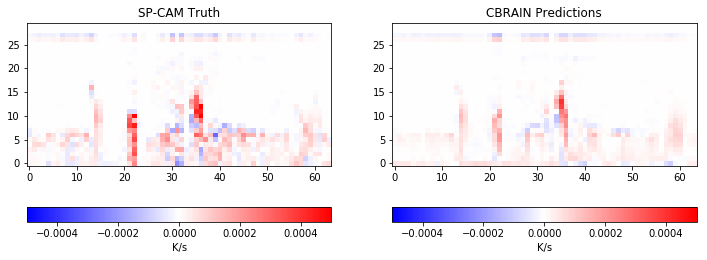

In [93]:
plot_double_slice(t[:, 0, :].T, p[:, 0, :].T, unit='K/s', cmap='bwr', 
                  vmin=-5e-4, vmax=5e-4, origin='lower')

## Try to get dataloader to work for maybe faster loading of data...

In [3]:
from utils import load_config
from dataLoad import DataLoader

In [8]:
model_dir = './logs/0219_213929_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_relu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_256_loss_mse'; model_dir

'./logs/0219_213929_SPDT,SPDQ_layers_1024,1024_lr_0.00025_ac_relu_conv_False_locconv_False_vars_TAP,QAP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic_batchs_256_loss_mse'

In [9]:
from config import parser

In [10]:
config, unparset = parser.parse_known_args(); config

Namespace(act='relu', addon='', batch_size=256, beta1=0.5, beta2=0.999, convert_units=False, convo=False, data_dir='data', epoch=200, filter_size=3, frac_train=0.8, gamma=0.5, hidden='1024,1024', input_names='TBP,QBP,PS,lat,SOLIN,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic', is_train=True, keep_dropout_rate=1.0, lambda_k=0.001, load_path='', local=False, localConvo=False, log_dir='logs', log_level='INFO', log_step=50, lossfct='mse', lr=0.00025, lr_lower_boundary=2e-08, lr_update_epoch=1, lr_update_step=5000, max_step=1000000, nlevs_imposed=0, normalizeInoutputs=True, num_log_samples=3, optimizer='adam', output_names='SPDT,SPDQ', random_seed=123, randomize=True, run_validation=True, save_step=1000, trivial_init=0, use_gpu=True)

In [11]:
setattr(config, 'input_names', ','.join(inps))
setattr(config, 'output_names', ','.join(outps)); config

Namespace(act='relu', addon='', batch_size=256, beta1=0.5, beta2=0.999, convert_units=False, convo=False, data_dir='data', epoch=200, filter_size=3, frac_train=0.8, gamma=0.5, hidden='1024,1024', input_names='TBP,QBP,PS,SHFLX,LHFLX,dTdt_adiabatic,dQdt_adiabatic', is_train=True, keep_dropout_rate=1.0, lambda_k=0.001, load_path='', local=False, localConvo=False, log_dir='logs', log_level='INFO', log_step=50, lossfct='mse', lr=0.00025, lr_lower_boundary=2e-08, lr_update_epoch=1, lr_update_step=5000, max_step=1000000, nlevs_imposed=0, normalizeInoutputs=True, num_log_samples=3, optimizer='adam', output_names='TPHYSTND_NORAD,PHQ', random_seed=123, randomize=True, run_validation=True, save_step=1000, trivial_init=0, use_gpu=True)

In [12]:
dl = DataLoader(data_dir, config, 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc')

self.varAllList ['TBP', 'QBP', 'PS', 'SHFLX', 'LHFLX', 'dTdt_adiabatic', 'dQdt_adiabatic', 'TPHYSTND_NORAD', 'PHQ']
/export/home/srasp/TF_models/mean_nolat_0213.nc
/export/home/srasp/TF_models/std_nolat_0213.nc
 raw_data_train_path /beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/*.nc 
['0000-01-01-00000', '0000-01-02-00000', '0000-01-03-00000']
last raw file: /beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0_enhance05
    title: 
    logname: tg847872
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    dimensions(sizes): lat(64), lon(128), lev(30), ilev(31), isccp_prs(7), isccp_tau(7), isccp_prstau(49), time(48), tbnd(2), chars(8), crm_x(8), crm_y(1), crm_z(28)
    variables(


/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  QCAP (48, 30, 64, 128) 

/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  QIAP (48, 30, 64, 128) 

/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  QRL (48, 30, 64, 128) 

/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  QRS (48, 30, 64, 128) 

/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  SHFLX (48, 64, 128) 

/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  SOLIN (48, 64, 128) 

/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old_matlab/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-03-14-00000.nc:  SPD

In [13]:
??dl.accessTimeData()

In [15]:
aqua = nc.Dataset(data_dir + 'AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc')

In [16]:
X = dl.accessTimeData(aqua, inps, iTim=1, doLog=True)

accessTimeData varDim[k]= 4 fileReader[k]= (48, 30, 64, 128)
TBP ----> arr= (30, 64, 128)
TBP --------> arr= (30, 64, 128)
TBP ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 4 fileReader[k]= (48, 30, 64, 128)
QBP ----> arr= (30, 64, 128)
QBP --------> arr= (30, 64, 128)
QBP ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 3 fileReader[k]= (48, 64, 128)
PS ----> arr= (1, 64, 128)
PS --------> arr= (1, 64, 128)
PS ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 3 fileReader[k]= (48, 64, 128)
SHFLX ----> arr= (1, 64, 128)
SHFLX --------> arr= (1, 64, 128)
SHFLX ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 3 fileReader[k]= (48, 64, 128)
LHFLX ----> arr= (1, 64, 128)
LHFLX --------> arr= (1, 64, 128)
LHFLX ------------> arr= (30, 64, 128)
accessTimeData varDim[k]= 4 fileReader[k]= (48, 30, 64, 128)
dTdt_adiabatic ----> arr= (30, 64, 128)
dTdt_adiabatic --------> arr= (30, 64, 128)
dTdt_adiabatic ------------> arr= (30, 64, 128)
accessTimeData v

In [17]:
X.shape

(7, 30, 64, 128)